In [54]:
from xor_data import xor_dataloaders
import torch
in_dim = 100
time = 100
samples_per_type = 100
batch_size = 20

train_loader, test_loader = xor_dataloaders(in_dim=in_dim,time=time,samples_per_type=samples_per_type,batch_size=batch_size)


In [48]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'device: {device}')
else:
    device = torch.device("cpu")
    print(f'device: {device}')

device: cuda


In [71]:
from LIFlayer import NHiddenModel
import torch
from Selfish_RNN.sparse_rnn_core import Masking,CosineDecay

num_hidden_layers = 0
in_channels = in_dim
hidden_channels = in_channels
out_channels = 2
with_recurrent = False

epochs=10

model = NHiddenModel(num_hidden_layers=num_hidden_layers,in_channels=in_channels,hidden_channels=hidden_channels,out_channels=out_channels,with_recurrent=with_recurrent).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
loss = torch.nn.CrossEntropyLoss()

#masking vars
death_rate = .5
decay_steps = len(train_loader) * epochs
density = .1

mask = None
cos_decay = CosineDecay(death_rate,decay_steps)
mask = Masking(optimizer,death_rate_decay=cos_decay,death_rate=death_rate,growth_mode='random',redistribution_mode='none')
mask.add_module(model,density=density)
mask.init(density=density)

Removed 2 layers.
layers.0.fc_layer.weight 0
layers.1.fc_layer.weight 0
Death rate: 0.5

layers.0.fc_layer.weight 1037
layers.1.fc_layer.weight 17
Death rate: 0.5



In [73]:
from tqdm import trange



decay = .99
tepochs = trange(epochs,desc=f'accuracy')
#print((model.layers[0].fc_layer.weight.data.cpu()==0).sum())
layer_vis={}
for e in tepochs:
    #print((model.layers[0].fc_layer.weight.data.cpu() !=0).sum())
    layer_vis[f'epoch_{e}_layer_0'] = model.layers[0].fc_layer.weight.data.cpu() ==0
    layer_vis[f'epoch_{e}_layer_1'] = model.layers[1].fc_layer.weight.data.cpu() ==0 
    #layer_vis[f'epoch_{e}_layer_2'] = model.layers[2].fc_layer.weight.data.cpu() ==0
    mean_loss = []
    mean_acc = []
    for x,label in train_loader:
        model.init_states()
        Sprobe = torch.zeros((train_loader.batch_size,model.out_channels),device=device)
        x = x.float().to(device)
        label=label.to(device)
        optimizer.zero_grad()
        for n in range(time):
            out_state = model(x[:,n])
            Sprobe = decay * Sprobe + out_state.S
        
        prediction = Sprobe
        accuracy = (label == prediction.argmax(axis=1)).sum()/len(prediction)
        batch_loss = loss(prediction,label)
        mean_loss.append(batch_loss.item())
        mean_acc.append(accuracy.item())
        batch_loss.backward()
        if mask is not None: mask.step()
        else: optimizer.step()
        optimizer.step()
    #truncate and grow weights
    
    mask.at_end_of_epoch(e)

    
    
    mean_loss = sum(mean_loss)/len(train_loader)
    mean_acc = sum(mean_acc)/len(train_loader)
    tepochs.set_description(f'accuracy: {mean_acc}')
    print((model.layers[0].fc_layer.weight.data.cpu()==0).sum())

accuracy: 0.4906250089406967:  10%|█         | 1/10 [00:01<00:10,  1.16s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.4879459980713597
Name: layers.1.fc_layer.weight pruning_rate 0.5294117647058824
1054.0 1020.0 -42.0
old, new nonzero count: 1054.0 1044 -42.0
layers.0.fc_layer.weight: 1037.0->1023, density: 0.102, proportion: 0.5000
layers.1.fc_layer.weight: 17.0->21, density: 0.105, proportion: 0.5000
Death rate: 0.4878864877830505

tensor(8984)


accuracy: 0.6750000193715096:  20%|██        | 2/10 [00:02<00:09,  1.14s/it]

Error resolving the residual! Layers are too full! Residual left over: 2.842170943040401e-14
Name: layers.0.fc_layer.weight pruning_rate 0.45356793743890517
Name: layers.1.fc_layer.weight pruning_rate 0.47619047619047616
1044.0 1020.0 -43.75
old, new nonzero count: 1044.0 1037 -43.75
layers.0.fc_layer.weight: 1023.0->1021, density: 0.102, proportion: 0.5000
layers.1.fc_layer.weight: 21.0->16, density: 0.080, proportion: 0.5000
Death rate: 0.4527317061077995

tensor(8987)


accuracy: 0.9156250096857548:  30%|███       | 3/10 [00:03<00:08,  1.15s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.39862879529872675
Name: layers.1.fc_layer.weight pruning_rate 0.4375
1037.0 1020.0 -27.854166666666664
old, new nonzero count: 1037.0 1023 -27.854166666666664
layers.0.fc_layer.weight: 1021.0->1010, density: 0.101, proportion: 0.5000
layers.1.fc_layer.weight: 16.0->13, density: 0.065, proportion: 0.5000
Death rate: 0.397976849942387

tensor(8992)


accuracy: 1.0:  40%|████      | 4/10 [00:04<00:06,  1.15s/it]               

Name: layers.0.fc_layer.weight pruning_rate 0.3297029702970297
Name: layers.1.fc_layer.weight pruning_rate 0.38461538461538464
1023.0 1020.0 -77.96354166666666
old, new nonzero count: 1023.0 1080 -77.96354166666666
layers.0.fc_layer.weight: 1010.0->1064, density: 0.106, proportion: 0.5000
layers.1.fc_layer.weight: 13.0->16, density: 0.080, proportion: 0.5000
Death rate: 0.3289817061077995

tensor(8942)


accuracy: 0.9812499992549419:  50%|█████     | 5/10 [00:05<00:05,  1.15s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.25281954887218044
Name: layers.1.fc_layer.weight pruning_rate 0.3125
1080.0 1020.0 -70.69088541666666
old, new nonzero count: 1080.0 1052 -70.69088541666666
layers.0.fc_layer.weight: 1064.0->1036, density: 0.104, proportion: 0.5000
layers.1.fc_layer.weight: 16.0->16, density: 0.080, proportion: 0.5000
Death rate: 0.2524999999999999

tensor(8965)


accuracy: 1.0:  60%|██████    | 6/10 [00:06<00:04,  1.15s/it]               

Name: layers.0.fc_layer.weight pruning_rate 0.17664092664092665
Name: layers.1.fc_layer.weight pruning_rate 0.1875
1052.0 1020.0 -71.5060546875
old, new nonzero count: 1052.0 1054 -71.5060546875
layers.0.fc_layer.weight: 1036.0->1041, density: 0.104, proportion: 0.5000
layers.1.fc_layer.weight: 16.0->13, density: 0.065, proportion: 0.5000
Death rate: 0.17601829389220044

tensor(8960)


accuracy: 1.0:  70%|███████   | 7/10 [00:08<00:03,  1.15s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.10758885686839577
Name: layers.1.fc_layer.weight pruning_rate 0.15384615384615385
1054.0 1020.0 -72.51937081473214
old, new nonzero count: 1054.0 1054 -72.51937081473214
layers.0.fc_layer.weight: 1041.0->1035, density: 0.103, proportion: 0.5000
layers.1.fc_layer.weight: 13.0->19, density: 0.095, proportion: 0.5000
Death rate: 0.10702315005761284

tensor(8965)


accuracy: 1.0:  80%|████████  | 8/10 [00:09<00:02,  1.14s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.05314009661835749
Name: layers.1.fc_layer.weight pruning_rate 0.05263157894736842
1054.0 1020.0 -71.62984270368304
old, new nonzero count: 1054.0 1052 -71.62984270368304
layers.0.fc_layer.weight: 1035.0->1034, density: 0.103, proportion: 0.5000
layers.1.fc_layer.weight: 19.0->18, density: 0.090, proportion: 0.5000
Death rate: 0.05226829389220049

tensor(8966)


accuracy: 1.0:  90%|█████████ | 9/10 [00:10<00:01,  1.14s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.017408123791102514
Name: layers.1.fc_layer.weight pruning_rate 0.05555555555555555
1052.0 1020.0 -69.96301623147632
old, new nonzero count: 1052.0 1050 -69.96301623147632
layers.0.fc_layer.weight: 1034.0->1033, density: 0.103, proportion: 0.5000
layers.1.fc_layer.weight: 18.0->17, density: 0.085, proportion: 0.5000
Death rate: 0.017113512216949484

tensor(8967)


accuracy: 1.0: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

Name: layers.0.fc_layer.weight pruning_rate 0.005808325266214908
Name: layers.1.fc_layer.weight pruning_rate 0.058823529411764705
1050.0 1020.0 -78.09075405786908
old, new nonzero count: 1050.0 1060 -78.09075405786908
layers.0.fc_layer.weight: 1033.0->1043, density: 0.104, proportion: 0.5000
layers.1.fc_layer.weight: 17.0->17, density: 0.085, proportion: 0.5000
Death rate: 0.005

tensor(8957)


In [65]:
print((model.layers[0].fc_layer.weight.data.cpu()==0).sum())

tensor(8970)


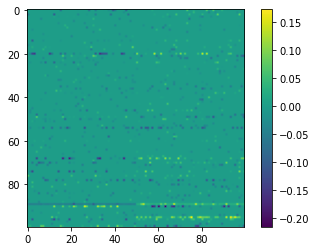

In [74]:
import matplotlib.pyplot as plt
plt.imshow(model.layers[0].fc_layer.weight.data.cpu())
plt.colorbar()